In [1]:
# LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ÌïúÍ∏Ä Ìè∞Ìä∏
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú

df = pd.read_csv('../data/processed_features.csv')

print(f"ÌÅ¨Í∏∞: {df.shape}")
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed_features.csv'

label
0    1507
1     649
Name: count, dtype: int64

ÎπÑÏú®:
label
0    0.69898
1    0.30102
Name: proportion, dtype: float64


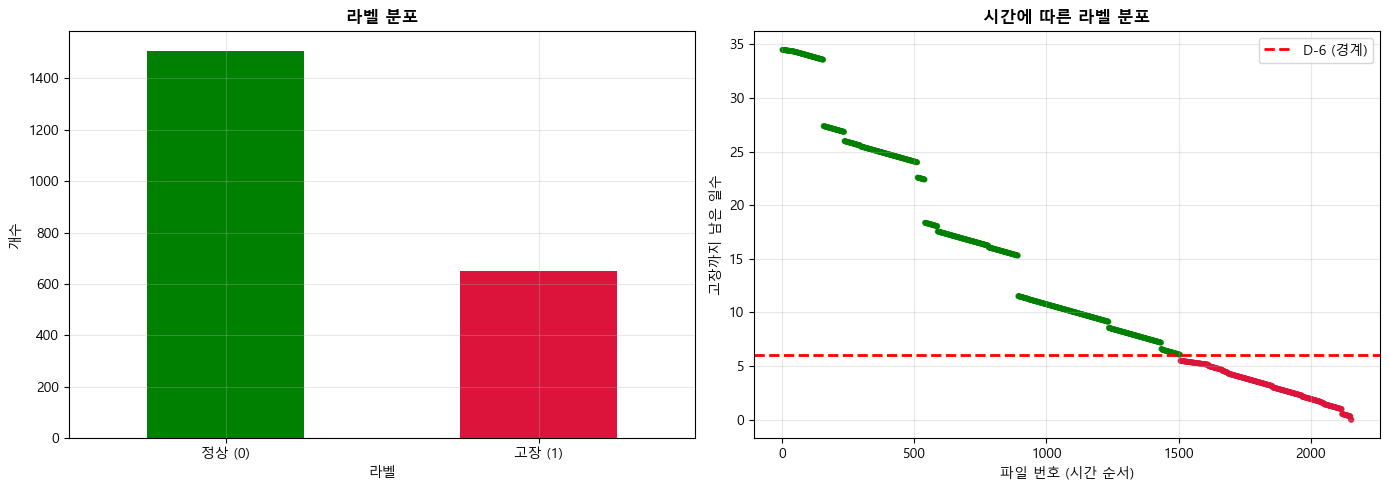

   Ï†ïÏÉÅ ÏÉòÌîå: 1507Í∞ú
   Í≥†Ïû• ÏÉòÌîå: 649Í∞ú


In [ ]:
# 2. ÎùºÎ≤® ÏÉùÏÑ±

# Î∞©Î≤ï: Í≥†Ïû• D-6Ïùº Ïù¥ÎÇ¥Î©¥ Í≥†Ïû•(1), ÏïÑÎãàÎ©¥ Ï†ïÏÉÅ(0)
threshold_days = 6

df['label'] = (df['days_to_failure'] <= threshold_days).astype(int)

# ÎùºÎ≤® Î∂ÑÌè¨ ÌôïÏù∏
print(df['label'].value_counts())
print(f"\nÎπÑÏú®:")
print(df['label'].value_counts(normalize=True))

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ÎùºÎ≤® Î∂ÑÌè¨
ax1 = axes[0]
df['label'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'crimson'])
ax1.set_title('ÎùºÎ≤® Î∂ÑÌè¨', fontsize=12, fontweight='bold')
ax1.set_xlabel('ÎùºÎ≤®')
ax1.set_ylabel('Í∞úÏàò')
ax1.set_xticklabels(['Ï†ïÏÉÅ (0)', 'Í≥†Ïû• (1)'], rotation=0)
ax1.grid(True, alpha=0.3)

# ÏãúÍ∞ÑÏóê Îî∞Î•∏ ÎùºÎ≤®
ax2 = axes[1]
x = range(len(df))
colors = ['green' if label == 0 else 'crimson' for label in df['label']]
ax2.scatter(x, df['days_to_failure'], c=colors, alpha=0.5, s=10)
ax2.axhline(y=threshold_days, color='red', linestyle='--', linewidth=2, 
            label=f'D-{threshold_days} (Í≤ΩÍ≥Ñ)')
ax2.set_title('ÏãúÍ∞ÑÏóê Îî∞Î•∏ ÎùºÎ≤® Î∂ÑÌè¨', fontsize=12, fontweight='bold')
ax2.set_xlabel('ÌååÏùº Î≤àÌò∏ (ÏãúÍ∞Ñ ÏàúÏÑú)')
ax2.set_ylabel('Í≥†Ïû•ÍπåÏßÄ ÎÇ®ÏùÄ ÏùºÏàò')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"   Ï†ïÏÉÅ ÏÉòÌîå: {(df['label']==0).sum()}Í∞ú")
print(f"   Í≥†Ïû• ÏÉòÌîå: {(df['label']==1).sum()}Í∞ú")

ÌäπÏÑ± Ïª¨Îüº: 32Í∞ú

Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞: 1507Í∞ú
Í≥†Ïû• Îç∞Ïù¥ÌÑ∞: 649Í∞ú

Î∂ÑÌï† ÏôÑÎ£å:
  Train: (1508, 37)
  Val:   (323, 37)
  Test:  (325, 37)

ÎùºÎ≤® Î∂ÑÌè¨:
  Train - Ï†ïÏÉÅ: 1054, Í≥†Ïû•:  454 (30.1%)
  Val   - Ï†ïÏÉÅ:  226, Í≥†Ïû•:   97 (30.0%)
  Test  - Ï†ïÏÉÅ:  227, Í≥†Ïû•:   98 (30.2%)


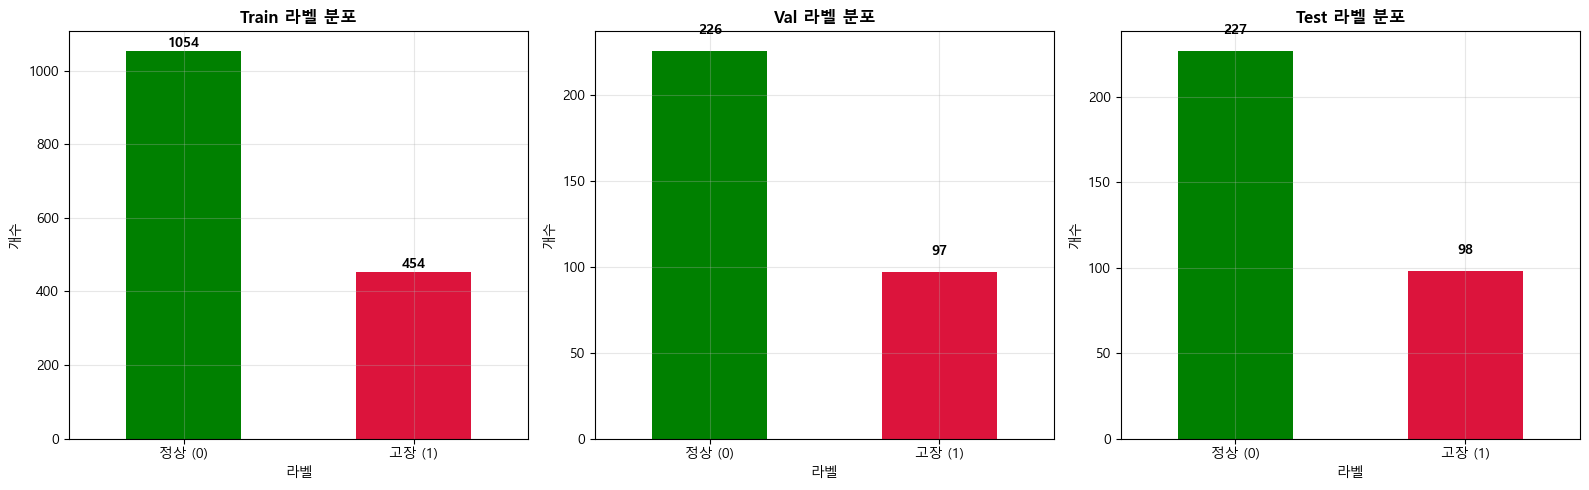

In [27]:
# 3. Train/Val/Test Î∂ÑÌï† (Í≥ÑÏ∏µÏ†Å Î∂ÑÌï†)

# ÌäπÏÑ± Ïª¨Îüº ÏÑ†ÌÉù
feature_cols = [col for col in df.columns if col.startswith('ch')]
print(f"ÌäπÏÑ± Ïª¨Îüº: {len(feature_cols)}Í∞ú")

# ÏãúÍ≥ÑÏó¥ Î∂àÍ∑†Ìòï Î¨∏Ï†ú
# -> Ï†ïÏÉÅ Îç∞Ïù¥ÌÑ∞: Ï¥àÎ∞ò ÏßëÏ§ë
# -> Í≥†Ïû• Îç∞Ïù¥ÌÑ∞: ÌõÑÎ∞ò ÏßëÏ§ë
# = ÏãúÍ∞Ñ ÏàúÏÑú Î∂ÑÌï† Ïãú TrainÏóê Í≥†Ïû• ÏÉòÌîå ÏóÜÏùå
# Ìï¥Í≤∞Ï±Ö: Í≥ÑÏ∏µÏ†Å Î∂ÑÌï† (Í∞Å ÌÅ¥ÎûòÏä§Î≥ÑÎ°ú 70/15/15)")

# Ï†ïÏÉÅÍ≥º Í≥†Ïû• Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
normal_data = df[df['label']==0].copy()
failure_data = df[df['label']==1].copy()

print(f"\nÏ†ïÏÉÅ Îç∞Ïù¥ÌÑ∞: {len(normal_data)}Í∞ú")
print(f"Í≥†Ïû• Îç∞Ïù¥ÌÑ∞: {len(failure_data)}Í∞ú")

# Í∞ÅÍ∞Å 70/15/15 Î∂ÑÌï†
def split_data(data, train_ratio=0.7, val_ratio=0.15):
    n = len(data)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    train = data.iloc[:train_end]
    val = data.iloc[train_end:val_end]
    test = data.iloc[val_end:]
    
    return train, val, test

normal_train, normal_val, normal_test = split_data(normal_data)
failure_train, failure_val, failure_test = split_data(failure_data)

# Ìï©ÏπòÍ∏∞
train_data = pd.concat([normal_train, failure_train], ignore_index=True)
val_data = pd.concat([normal_val, failure_val], ignore_index=True)
test_data = pd.concat([normal_test, failure_test], ignore_index=True)

# ÏÑûÍ∏∞ (ÏÑ†ÌÉù)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nÎ∂ÑÌï† ÏôÑÎ£å:")
print(f"  Train: {train_data.shape}")
print(f"  Val:   {val_data.shape}")
print(f"  Test:  {test_data.shape}")

# ÎùºÎ≤® Î∂ÑÌè¨
print(f"\nÎùºÎ≤® Î∂ÑÌè¨:")
print(f"  Train - Ï†ïÏÉÅ: {(train_data['label']==0).sum():4d}, Í≥†Ïû•: {(train_data['label']==1).sum():4d} ({(train_data['label']==1).sum()/len(train_data)*100:.1f}%)")
print(f"  Val   - Ï†ïÏÉÅ: {(val_data['label']==0).sum():4d}, Í≥†Ïû•: {(val_data['label']==1).sum():4d} ({(val_data['label']==1).sum()/len(val_data)*100:.1f}%)")
print(f"  Test  - Ï†ïÏÉÅ: {(test_data['label']==0).sum():4d}, Í≥†Ïû•: {(test_data['label']==1).sum():4d} ({(test_data['label']==1).sum()/len(test_data)*100:.1f}%)")

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, data) in enumerate([('Train', train_data), ('Val', val_data), ('Test', test_data)]):
    ax = axes[idx]
    
    data['label'].value_counts().plot(kind='bar', ax=ax, 
                                       color=['green', 'crimson'])
    ax.set_title(f'{name} ÎùºÎ≤® Î∂ÑÌè¨', fontsize=12, fontweight='bold')
    ax.set_xlabel('ÎùºÎ≤®')
    ax.set_ylabel('Í∞úÏàò')
    ax.set_xticklabels(['Ï†ïÏÉÅ (0)', 'Í≥†Ïû• (1)'], rotation=0)
    ax.grid(True, alpha=0.3)
    
    # Í∞í ÌëúÏãú
    for i, v in enumerate(data['label'].value_counts()):
        ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [28]:
# 4. ÏãúÍ≥ÑÏó¥ ÏúàÎèÑÏö∞ ÏÉùÏÑ±

print("\nÏãúÍ≥ÑÏó¥ ÏúàÎèÑÏö∞ ÏÉùÏÑ±")
print("-" * 60)

# ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞ ÏÑ§Ï†ï
window_size = 10  # Í≥ºÍ±∞ 10Í∞ú ÏãúÏ†êÏúºÎ°ú ÏòàÏ∏°

# ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞: Í≥ºÍ±∞ {window_size}Ïùº Îç∞Ïù¥ÌÑ∞Î°ú Ïò§Îäò ÏòàÏ∏°

# ÏúàÎèÑÏö∞ ÏÉùÏÑ± Ìï®Ïàò
def create_sequences(data, feature_cols, window_size):
    """
    ÏãúÍ≥ÑÏó¥ ÏúàÎèÑÏö∞ ÏÉùÏÑ±
    
    ÏûÖÎ†•:
    - data: DataFrame
    - feature_cols: ÌäπÏÑ± Ïª¨Îüº Î¶¨Ïä§Ìä∏
    - window_size: ÏúàÎèÑÏö∞ ÌÅ¨Í∏∞
    
    Ï∂úÎ†•:
    - X: (samples, window_size, features) 3D Î∞∞Ïó¥
    - y: (samples,) ÎùºÎ≤®
    """
    X = []
    y = []
    
    # timestampÎ°ú Ï†ïÎ†¨ (ÏãúÍ∞Ñ ÏàúÏÑú Î≥¥Ïû•)
    data = data.sort_values('timestamp').reset_index(drop=True)
    
    # Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞
    for i in range(len(data) - window_size):
        # Í≥ºÍ±∞ window_sizeÍ∞ú Îç∞Ïù¥ÌÑ∞
        window = data.iloc[i:i+window_size][feature_cols].values
        
        # ÏòàÏ∏° ÎåÄÏÉÅ (window Îã§Ïùå ÏãúÏ†ê)
        label = data.iloc[i+window_size]['label']
        
        X.append(window)
        y.append(label)
    
    return np.array(X), np.array(y)

# Í∞Å ÏÑ∏Ìä∏Î≥ÑÎ°ú ÏúàÎèÑÏö∞ ÏÉùÏÑ±
X_train, y_train = create_sequences(train_data, feature_cols, window_size)
X_val, y_val = create_sequences(val_data, feature_cols, window_size)
X_test, y_test = create_sequences(test_data, feature_cols, window_size)

print(f"\nTrain:")
print(f"  X_train: {X_train.shape} (samples, timesteps, features)")
print(f"  y_train: {y_train.shape}")
print(f"  Í≥†Ïû• ÎπÑÏú®: {y_train.sum() / len(y_train) * 100:.1f}%")

print(f"\nVal:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  Í≥†Ïû• ÎπÑÏú®: {y_val.sum() / len(y_val) * 100:.1f}%")

print(f"\nTest:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Í≥†Ïû• ÎπÑÏú®: {y_test.sum() / len(y_test) * 100:.1f}%")



ÏãúÍ≥ÑÏó¥ ÏúàÎèÑÏö∞ ÏÉùÏÑ±
------------------------------------------------------------

Train:
  X_train: (1498, 10, 32) (samples, timesteps, features)
  y_train: (1498,)
  Í≥†Ïû• ÎπÑÏú®: 30.3%

Val:
  X_val: (313, 10, 32)
  y_val: (313,)
  Í≥†Ïû• ÎπÑÏú®: 31.0%

Test:
  X_test: (315, 10, 32)
  y_test: (315,)
  Í≥†Ïû• ÎπÑÏú®: 31.1%


In [29]:
# 5. Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî
from sklearn.preprocessing import StandardScaler

# Train Îç∞Ïù¥ÌÑ∞Î°ú Scaler ÌïôÏäµ

# 3D ‚Üí 2DÎ°ú reshape
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
print(f"   X_train ÌòïÌÉú Î≥ÄÌôò: {X_train.shape} ‚Üí {X_train_2d.shape}")

# Scaler ÌïôÏäµ
scaler = StandardScaler()
scaler.fit(X_train_2d)

# Ï†ïÍ∑úÌôî Ï†Ñ ÌÜµÍ≥Ñ
print(f"\nÏ†ïÍ∑úÌôî Ï†Ñ (Train):")
print(f"   ÌèâÍ∑†: {X_train_2d.mean(axis=0)[:3]} ... (Ï≤òÏùå 3Í∞ú)")
print(f"   ÌëúÏ§ÄÌé∏Ï∞®: {X_train_2d.std(axis=0)[:3]} ...")

# Ï†ïÍ∑úÌôî Ï†ÅÏö©

# Train
X_train_scaled = scaler.transform(X_train_2d)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
print(f"   Train: {X_train.shape} ‚Üí {X_train_scaled.shape}")

# Val
X_val_2d = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled = scaler.transform(X_val_2d)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
print(f"   Val:   {X_val.shape} ‚Üí {X_val_scaled.shape}")

# Test
X_test_2d = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_2d)
X_test_scaled = X_test_scaled.reshape(X_test.shape)
print(f"   Test:  {X_test.shape} ‚Üí {X_test_scaled.shape}")

# Ï†ïÍ∑úÌôî ÌõÑ ÌÜµÍ≥Ñ
X_train_2d_scaled = X_train_scaled.reshape(-1, X_train_scaled.shape[-1])
print(f"\nÏ†ïÍ∑úÌôî ÌõÑ (Train):")
print(f"   ÌèâÍ∑†: {X_train_2d_scaled.mean(axis=0)[:3]} ... (Í±∞Ïùò 0)")
print(f"   ÌëúÏ§ÄÌé∏Ï∞®: {X_train_2d_scaled.std(axis=0)[:3]} ... (Í±∞Ïùò 1)")


   X_train ÌòïÌÉú Î≥ÄÌôò: (1498, 10, 32) ‚Üí (14980, 32)

Ï†ïÍ∑úÌôî Ï†Ñ (Train):
   ÌèâÍ∑†: [0.15125067 0.71866389 0.0979136 ] ... (Ï≤òÏùå 3Í∞ú)
   ÌëúÏ§ÄÌé∏Ï∞®: [0.00798489 0.08051435 0.00531836] ...
   Train: (1498, 10, 32) ‚Üí (1498, 10, 32)
   Val:   (313, 10, 32) ‚Üí (313, 10, 32)
   Test:  (315, 10, 32) ‚Üí (315, 10, 32)

Ï†ïÍ∑úÌôî ÌõÑ (Train):
   ÌèâÍ∑†: [-5.13487561e-14  3.19595855e-14  1.48720214e-13] ... (Í±∞Ïùò 0)
   ÌëúÏ§ÄÌé∏Ï∞®: [1. 1. 1.] ... (Í±∞Ïùò 1)


In [30]:
# 6. LSTM Î™®Îç∏ Íµ¨Ï∂ï

# Î™®Îç∏ Íµ¨Ï°∞
model = Sequential([
    # LSTM Î†àÏù¥Ïñ¥ 1
    LSTM(64, activation='tanh', return_sequences=True, 
         input_shape=(window_size, len(feature_cols))),
    Dropout(0.2),
    
    # LSTM Î†àÏù¥Ïñ¥ 2
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    
    # Dense Î†àÏù¥Ïñ¥
    Dense(16, activation='relu'),
    Dropout(0.2),
    
    # Ï∂úÎ†• Î†àÏù¥Ïñ¥ (Ïù¥ÏßÑ Î∂ÑÎ•ò)
    Dense(1, activation='sigmoid')
])

# Î™®Îç∏ Ïª¥ÌååÏùº
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

# Î™®Îç∏ Íµ¨Ï°∞ Ï∂úÎ†•
model.summary()

print(f"   ÏûÖÎ†•: (None, {window_size}, {len(feature_cols)})")
print(f"   Ï∂úÎ†•: (None, 1) - Í≥†Ïû• ÌôïÎ•†")

Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ lstm_4 (LSTM)                   ‚îÇ (None, 10, 64)         ‚îÇ        24,832 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout)             ‚îÇ (None, 10, 64)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_5 (LSTM)                   ‚îÇ (None, 32)             ‚îÇ        12,416 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)             ‚îÇ (None, 32)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                 ‚îÇ (None, 16)             ‚îÇ           528 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_9 (Dropout)             ‚îÇ (None, 16)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                 ‚îÇ (None, 1)              ‚îÇ            17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 37,793 (147.63 KB)

 Trainable params: 37,793 (147.63 KB)

 Non-trainable params: 0 (0.00 B)

   ÏûÖÎ†•: (None, 10, 32)
   Ï∂úÎ†•: (None, 1) - Í≥†Ïû• ÌôïÎ•†


Epoch 1/100
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 21ms/step - accuracy: 0.8530 - loss: 0.4348 - precision: 0.7428 - recall: 0.9115 - val_accuracy: 0.9904 - val_loss: 0.0335 - val_precision: 0.9700 - val_recall: 1.0000
Epoch 2/100
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0305 - precision: 0.9981 - recall: 0.9915 - val_accuracy: 0.8658 - val_loss: 0.3602 - val_precision: 0.6978 - val_recall: 1.0000
Epoch 3/100
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step - accuracy: 0.9841 - loss: 0.0453 - precision: 0.9574 - recall: 0.9920 - val_accuracy: 0.9872 - val_loss: 0.0351 - val_precision: 0.9604 - val_recall: 1.0000
Epoch 4/100
47/47 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - accuracy: 0.9974 - loss: 0.0092 - precision: 0.9974 - recall: 0.9936 - val_accuracy: 0.9968 - val_loss: 0.0072 - val_precision: 0.9898 - val_recall: 1.0000
E

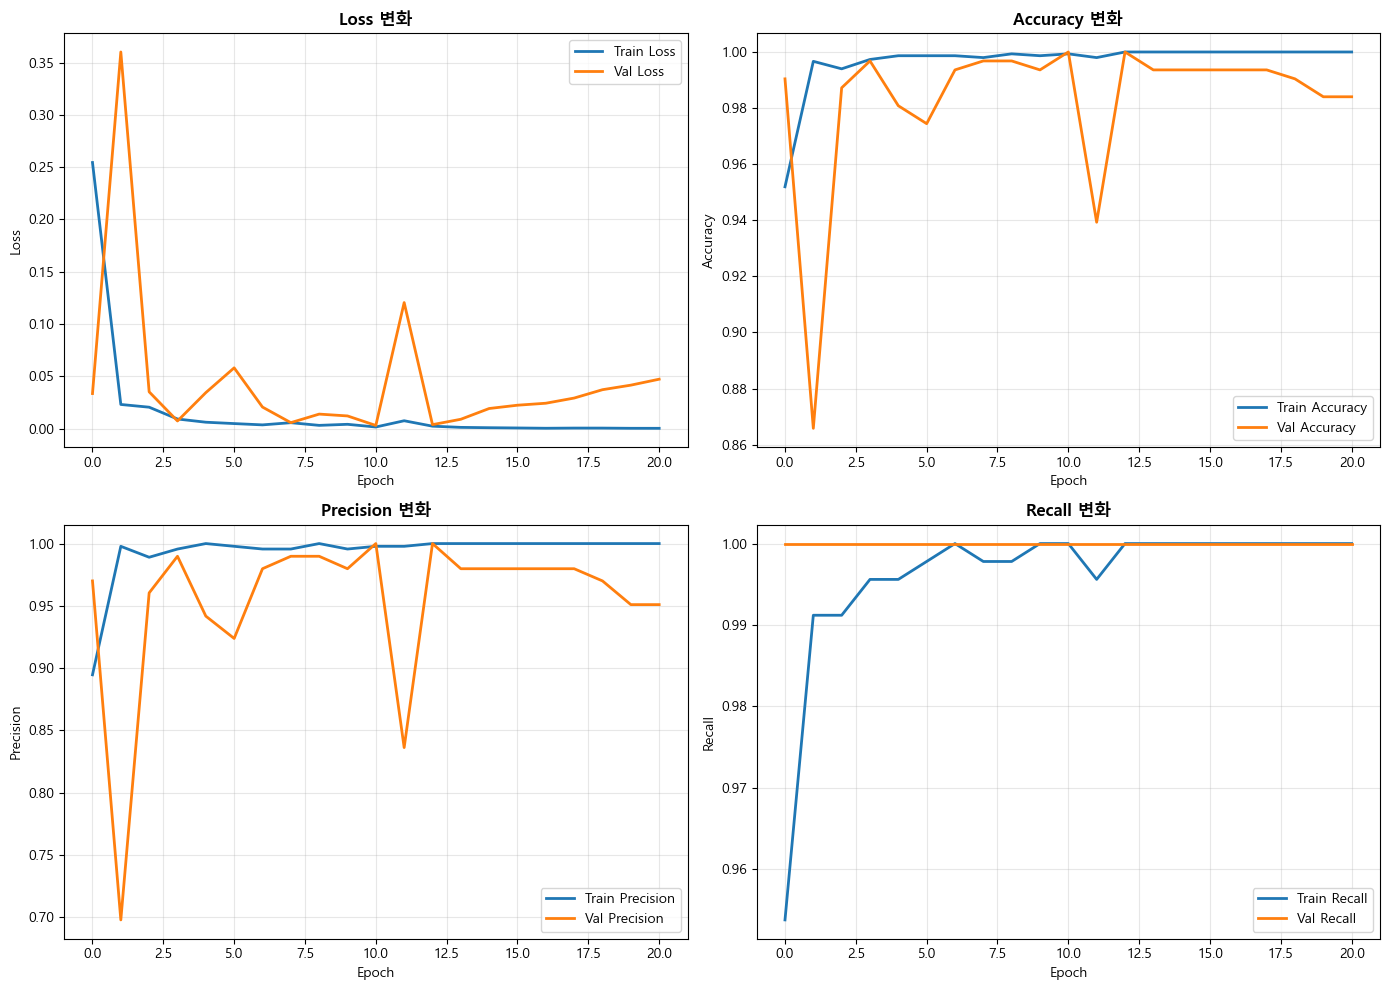

In [31]:
# 7. Î™®Îç∏ ÌïôÏäµ

# Early Stopping ÏÑ§Ï†ï
early_stop = EarlyStopping(
    monitor='val_loss',      # Val loss Î™®ÎãàÌÑ∞ÎßÅ
    patience=10,             # 10 epoch Í∞úÏÑ† ÏóÜÏúºÎ©¥ Ï§ëÎã®
    restore_best_weights=True,  # ÏµúÍ≥† ÏÑ±Îä• Î™®Îç∏Î°ú Î≥µÏõê
    verbose=1
)

# ÌïôÏäµ ÏãúÏûë

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# ÌïôÏäµ Í≤∞Í≥º ÏöîÏïΩ
print("\n ÏµúÏ¢Ö ÏÑ±Îä•:")
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"  Train Loss: {final_train_loss:.4f}")
print(f"  Train Acc:  {final_train_acc:.4f}")
print(f"  Val Loss:   {final_val_loss:.4f}")
print(f"  Val Acc:    {final_val_acc:.4f}")

# ÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî
print("\nÌïôÏäµ Í≥°ÏÑ† ÏãúÍ∞ÅÌôî")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Loss
ax = axes[0, 0]
ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_title('Loss Î≥ÄÌôî', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# 2) Accuracy
ax = axes[0, 1]
ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax.set_title('Accuracy Î≥ÄÌôî', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True, alpha=0.3)

# 3) Precision
ax = axes[1, 0]
ax.plot(history.history['precision'], label='Train Precision', linewidth=2)
ax.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
ax.set_title('Precision Î≥ÄÌôî', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Precision')
ax.legend()
ax.grid(True, alpha=0.3)

# 4) Recall
ax = axes[1, 1]
ax.plot(history.history['recall'], label='Train Recall', linewidth=2)
ax.plot(history.history['val_recall'], label='Val Recall', linewidth=2)
ax.set_title('Recall Î≥ÄÌôî', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


üéØ Test Îç∞Ïù¥ÌÑ∞ ÌèâÍ∞Ä
------------------------------------------------------------
ÏòàÏ∏° Ï§ë...
‚úÖ ÏòàÏ∏° ÏôÑÎ£å!

üìä Test ÏÑ±Îä•:
  Accuracy:  0.7714 (77.14%)
  Precision: 0.5765 (57.65%)
  Recall:    1.0000 (100.00%)

üìã Confusion Matrix:
[[145  72]
 [  0  98]]

  TN (True Negative):  145 - Ï†ïÏÉÅÏùÑ Ï†ïÏÉÅÏúºÎ°ú
  FP (False Positive): 72 - Ï†ïÏÉÅÏùÑ Í≥†Ïû•ÏúºÎ°ú (Í±∞Ïßì Í≤ΩÎ≥¥)
  FN (False Negative): 0 - Í≥†Ïû•ÏùÑ Ï†ïÏÉÅÏúºÎ°ú (ÎÜìÏπ®!) ‚ö†Ô∏è
  TP (True Positive):  98 - Í≥†Ïû•ÏùÑ Í≥†Ïû•ÏúºÎ°ú

üìà Classification Report:
              precision    recall  f1-score   support

      Ï†ïÏÉÅ (0)       1.00      0.67      0.80       217
      Í≥†Ïû• (1)       0.58      1.00      0.73        98

    accuracy                           0.77       315
   macro avg       0.79      0.83      0.77       315
weighted avg       0.87      0.77      0.78       315



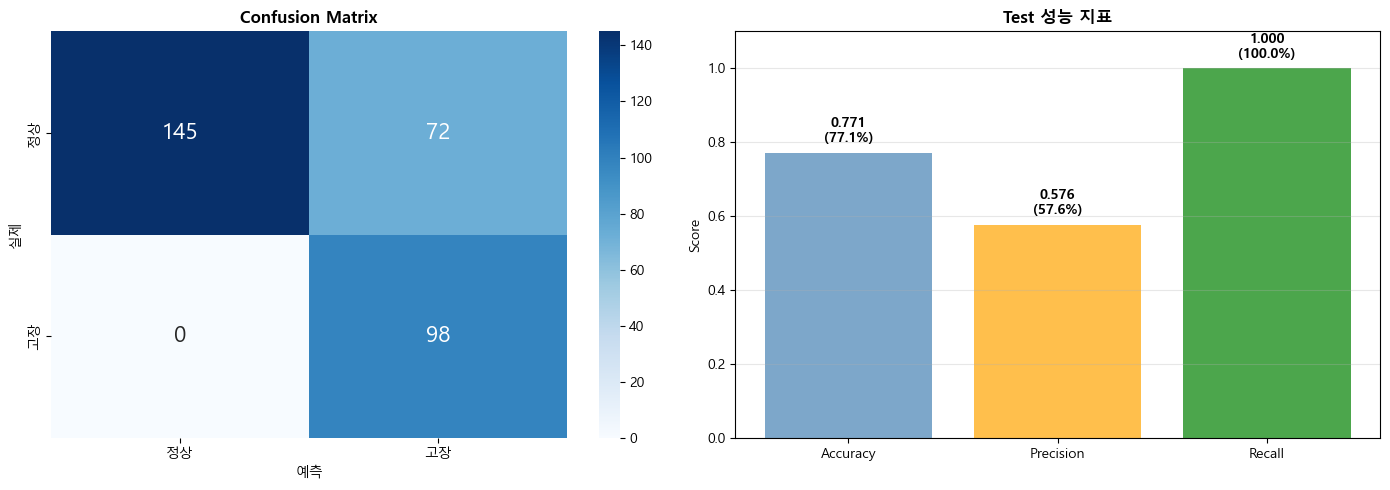


üîç Í≥ºÏ†ÅÌï© Ï≤¥ÌÅ¨
Train Acc: 1.0000 (100.00%)
Val Acc:   0.9840 (98.40%)
Test Acc:  0.7714 (77.14%)

Train-Test Ï∞®Ïù¥: 0.2286 (22.86%p)
‚ö†Ô∏è Í≥ºÏ†ÅÌï© Í∞ÄÎä•ÏÑ± ÎÜíÏùå (Ï∞®Ïù¥ > 10%)


In [ ]:
# 8. Test ÌèâÍ∞Ä

print("\nTest Îç∞Ïù¥ÌÑ∞ ÌèâÍ∞Ä")
print("-" * 60)

# ÏòàÏ∏°
print("ÏòàÏ∏° Ï§ë...")
y_pred_prob = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("ÏòàÏ∏° ÏôÑÎ£å!")

# ÏÑ±Îä• ÏßÄÌëú
from sklearn.metrics import classification_report, confusion_matrix

test_acc = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

print("\nTest ÏÑ±Îä•:")
print(f"  Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)
print(f"\n  TN (True Negative):  {cm[0,0]} - Ï†ïÏÉÅÏùÑ Ï†ïÏÉÅÏúºÎ°ú")
print(f"  FP (False Positive): {cm[0,1]} - Ï†ïÏÉÅÏùÑ Í≥†Ïû•ÏúºÎ°ú (Í±∞Ïßì Í≤ΩÎ≥¥)")
print(f"  FN (False Negative): {cm[1,0]} - Í≥†Ïû•ÏùÑ Ï†ïÏÉÅÏúºÎ°ú (ÎÜìÏπ®!) ‚ö†Ô∏è")
print(f"  TP (True Positive):  {cm[1,1]} - Í≥†Ïû•ÏùÑ Í≥†Ïû•ÏúºÎ°ú")

# Î∂ÑÎ•ò Î¶¨Ìè¨Ìä∏
print("\nClassification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['Ï†ïÏÉÅ (0)', 'Í≥†Ïû• (1)']))

# ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix ÌûàÌä∏Îßµ
ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ï†ïÏÉÅ', 'Í≥†Ïû•'],
            yticklabels=['Ï†ïÏÉÅ', 'Í≥†Ïû•'],
            ax=ax, cbar=True, annot_kws={'size': 16})
ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax.set_xlabel('ÏòàÏ∏°')
ax.set_ylabel('Ïã§Ï†ú')

# ÏÑ±Îä• ÏßÄÌëú ÎπÑÍµê
ax = axes[1]
metrics = ['Accuracy', 'Precision', 'Recall']
values = [test_acc, test_precision, test_recall]
colors = ['steelblue', 'orange', 'green']

bars = ax.bar(metrics, values, color=colors, alpha=0.7)
ax.set_ylim(0, 1.1)
ax.set_title('Test ÏÑ±Îä• ÏßÄÌëú', fontsize=12, fontweight='bold')
ax.set_ylabel('Score')
ax.grid(True, alpha=0.3, axis='y')

# Í∞í ÌëúÏãú
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.3f}\n({value*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Í≥ºÏ†ÅÌï© Ï≤¥ÌÅ¨
print("\n" + "=" * 60)
print("Í≥ºÏ†ÅÌï© Ï≤¥ÌÅ¨")
print("=" * 60)
print(f"Train Acc: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Val Acc:   {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Test Acc:  {test_acc:.4f} ({test_acc*100:.2f}%)")

gap_train_test = final_train_acc - test_acc
print(f"\nTrain-Test Ï∞®Ïù¥: {gap_train_test:.4f} ({gap_train_test*100:.2f}%p)")

if gap_train_test > 0.1:
    print("Í≥ºÏ†ÅÌï© Í∞ÄÎä•ÏÑ± ÎÜíÏùå (Ï∞®Ïù¥ > 10%)")
elif gap_train_test > 0.05:
    print("ÏïΩÍ∞Ñ Í≥ºÏ†ÅÌï© (Ï∞®Ïù¥ 5~10%)")
else:
    print("Í≥ºÏ†ÅÌï© ÏóÜÏùå (Ï∞®Ïù¥ < 5%)")


üìä ÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî
------------------------------------------------------------


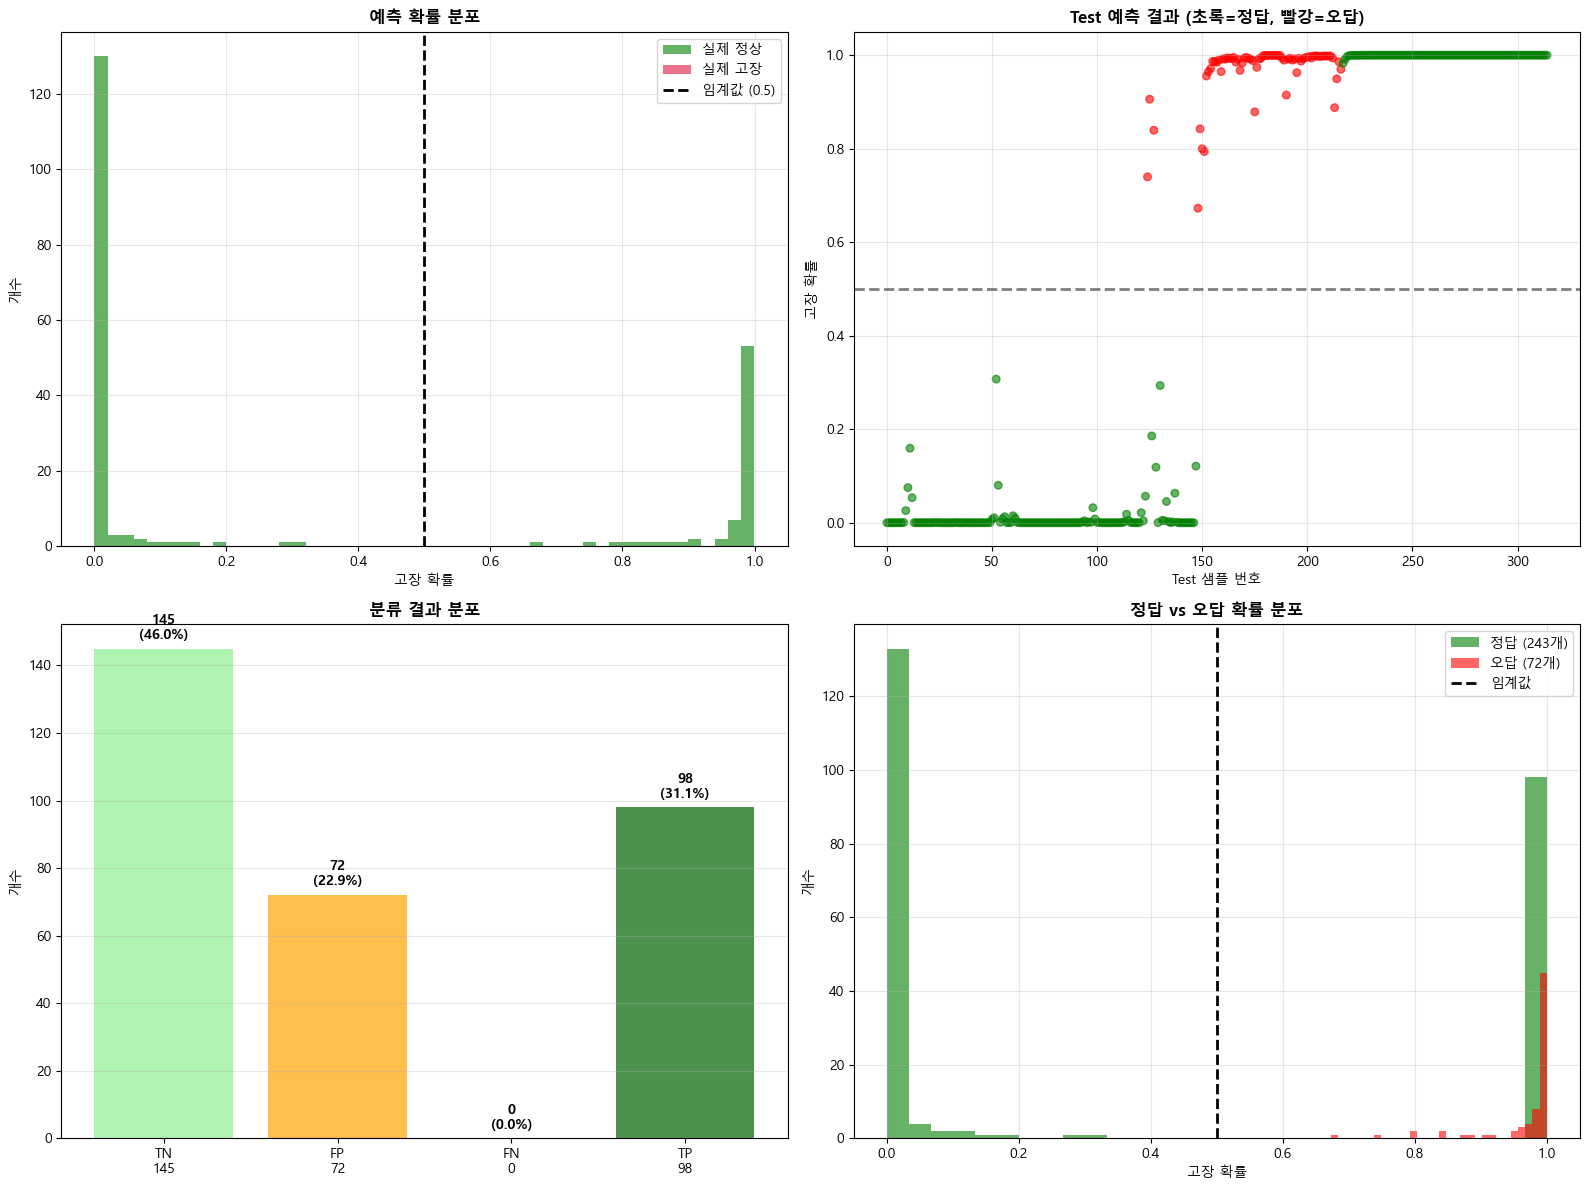


üîç Ïò§Î∂ÑÎ•ò ÏÉòÌîå Î∂ÑÏÑù:
------------------------------------------------------------

False Positive (Í±∞Ïßì Í≤ΩÎ≥¥): 72Í∞ú
  ÌèâÍ∑† ÌôïÎ•†: 0.967
  ÏµúÎåÄ ÌôïÎ•†: 1.000
  ÏµúÏÜå ÌôïÎ•†: 0.673

False Negative (ÎÜìÏπ®): 0Í∞ú ‚ö†Ô∏è

ü§î Í∞ÄÏû• Ïï†Îß§Ìïú ÏòàÏ∏° (0.5 Í∑ºÏ≤ò):
  0.4~0.6 ÏÇ¨Ïù¥: 0Í∞ú


In [ ]:
# 9. ÏòàÏ∏° ÏãúÍ∞ÅÌôî

print("\nÏòàÏ∏° Í≤∞Í≥º ÏãúÍ∞ÅÌôî")
print("-" * 60)

# ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ÏòàÏ∏° ÌôïÎ•† ÌûàÏä§ÌÜ†Í∑∏Îû®
ax = axes[0, 0]

# Ï†ïÏÉÅ/Í≥†Ïû• ÏÉòÌîåÎ≥Ñ ÌôïÎ•† Î∂ÑÌè¨
normal_probs = y_pred_prob[y_test == 0].flatten()
failure_probs = y_pred_prob[y_test == 1].flatten()

ax.hist(normal_probs, bins=50, alpha=0.6, label='Ïã§Ï†ú Ï†ïÏÉÅ', color='green')
ax.hist(failure_probs, bins=50, alpha=0.6, label='Ïã§Ï†ú Í≥†Ïû•', color='crimson')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='ÏûÑÍ≥ÑÍ∞í (0.5)')
ax.set_title('ÏòàÏ∏° ÌôïÎ•† Î∂ÑÌè¨', fontsize=12, fontweight='bold')
ax.set_xlabel('Í≥†Ïû• ÌôïÎ•†')
ax.set_ylabel('Í∞úÏàò')
ax.legend()
ax.grid(True, alpha=0.3)

# ÏãúÍ∞ÑÏóê Îî∞Î•∏ ÏòàÏ∏°
ax = axes[0, 1]

x = range(len(y_test))
colors = ['green' if actual == pred else 'red' 
          for actual, pred in zip(y_test, y_pred)]

scatter = ax.scatter(x, y_pred_prob.flatten(), c=colors, alpha=0.6, s=30)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_title('Test ÏòàÏ∏° Í≤∞Í≥º (Ï¥àÎ°ù=Ï†ïÎãµ, Îπ®Í∞ï=Ïò§Îãµ)', fontsize=12, fontweight='bold')
ax.set_xlabel('Test ÏÉòÌîå Î≤àÌò∏')
ax.set_ylabel('Í≥†Ïû• ÌôïÎ•†')
ax.grid(True, alpha=0.3)

# Ïò§Î∂ÑÎ•ò Î∂ÑÏÑù
ax = axes[1, 0]

# Ïò§Î∂ÑÎ•ò ÌÉÄÏûÖ
fp_mask = (y_test == 0) & (y_pred == 1)  # False Positive
fn_mask = (y_test == 1) & (y_pred == 0)  # False Negative
tp_mask = (y_test == 1) & (y_pred == 1)  # True Positive
tn_mask = (y_test == 0) & (y_pred == 0)  # True Negative

counts = [tn_mask.sum(), fp_mask.sum(), fn_mask.sum(), tp_mask.sum()]
labels = [f'TN\n{tn_mask.sum()}', f'FP\n{fp_mask.sum()}', 
          f'FN\n{fn_mask.sum()}', f'TP\n{tp_mask.sum()}']
colors_bar = ['lightgreen', 'orange', 'red', 'darkgreen']

bars = ax.bar(labels, counts, color=colors_bar, alpha=0.7)
ax.set_title('Î∂ÑÎ•ò Í≤∞Í≥º Î∂ÑÌè¨', fontsize=12, fontweight='bold')
ax.set_ylabel('Í∞úÏàò')
ax.grid(True, alpha=0.3, axis='y')

# Í∞í ÌëúÏãú
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{count}\n({count/len(y_test)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

# Ïò§Î∂ÑÎ•ò ÏÉòÌîåÏùò ÌôïÎ•† Î∂ÑÌè¨
ax = axes[1, 1]

correct_probs = y_pred_prob[(y_test == y_pred).flatten()].flatten()
wrong_probs = y_pred_prob[(y_test != y_pred).flatten()].flatten()

ax.hist(correct_probs, bins=30, alpha=0.6, label=f'Ï†ïÎãµ ({len(correct_probs)}Í∞ú)', 
        color='green')
ax.hist(wrong_probs, bins=30, alpha=0.6, label=f'Ïò§Îãµ ({len(wrong_probs)}Í∞ú)', 
        color='red')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='ÏûÑÍ≥ÑÍ∞í')
ax.set_title('Ï†ïÎãµ vs Ïò§Îãµ ÌôïÎ•† Î∂ÑÌè¨', fontsize=12, fontweight='bold')
ax.set_xlabel('Í≥†Ïû• ÌôïÎ•†')
ax.set_ylabel('Í∞úÏàò')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ïò§Î∂ÑÎ•ò ÏÉòÌîå Î∂ÑÏÑù
print("\nÏò§Î∂ÑÎ•ò ÏÉòÌîå Î∂ÑÏÑù:")
print("-" * 60)

print(f"\nFalse Positive (Í±∞Ïßì Í≤ΩÎ≥¥): {fp_mask.sum()}Í∞ú")
if fp_mask.sum() > 0:
    fp_probs = y_pred_prob[fp_mask].flatten()
    print(f"  ÌèâÍ∑† ÌôïÎ•†: {fp_probs.mean():.3f}")
    print(f"  ÏµúÎåÄ ÌôïÎ•†: {fp_probs.max():.3f}")
    print(f"  ÏµúÏÜå ÌôïÎ•†: {fp_probs.min():.3f}")

print(f"\nFalse Negative (ÎÜìÏπ®): {fn_mask.sum()}Í∞ú ‚ö†Ô∏è")
if fn_mask.sum() > 0:
    fn_probs = y_pred_prob[fn_mask].flatten()
    print(f"  ÌèâÍ∑† ÌôïÎ•†: {fn_probs.mean():.3f}")
    print(f"  ÏµúÎåÄ ÌôïÎ•†: {fn_probs.max():.3f}")
    print(f"  ÏµúÏÜå ÌôïÎ•†: {fn_probs.min():.3f}")

# Í∞ÄÏû• ÌôïÏã† ÏóÜÎäî ÏòàÏ∏°
print("\nÍ∞ÄÏû• Ïï†Îß§Ìïú ÏòàÏ∏° (0.5 Í∑ºÏ≤ò):")
ambiguous_mask = (y_pred_prob > 0.4) & (y_pred_prob < 0.6)
print(f"  0.4~0.6 ÏÇ¨Ïù¥: {ambiguous_mask.sum().sum()}Í∞ú")